In [2]:
import pandas as pd

# Load the data from the CSV file
file_path = 'train10000_syn.csv'  # Change this to the correct file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df['Time'] = pd.to_datetime(df['Time'])

# Set the 'Time' column as the index
df.set_index('Time', inplace=True)

# Filter for BUY and SELL orders
buy_orders = df['buy_orders']
sell_orders = df['sell_orders']


In [3]:
df

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:48,38,21
2024-10-14 07:53:49,51,22
2024-10-14 07:53:50,28,11
2024-10-14 07:53:51,14,9
2024-10-14 07:53:52,42,33
...,...,...
2024-10-14 10:40:23,14,1
2024-10-14 10:40:24,26,34
2024-10-14 10:40:25,3,8


In [4]:
order_counts=df

In [5]:
# Calculate OFI, avoid division by zero
order_counts['OFI'] = (order_counts['buy_orders'] - order_counts['sell_orders']) / (order_counts['buy_orders'] + order_counts['sell_orders'])

# Fill any NaN values (in case of zero division) with 0
order_counts['OFI'].fillna(0, inplace=True)

# Display the calculated OFI values
print(order_counts.head())


                     buy_orders  sell_orders       OFI
Time                                                  
2024-10-14 07:53:48          38           21  0.288136
2024-10-14 07:53:49          51           22  0.397260
2024-10-14 07:53:50          28           11  0.435897
2024-10-14 07:53:51          14            9  0.217391
2024-10-14 07:53:52          42           33  0.120000


C:\Users\user\AppData\Local\Temp\ipykernel_27252\3576943439.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_counts['OFI'].fillna(0, inplace=True)


In [6]:
df = order_counts 

In [7]:
df

,buy_orders,sell_orders,OFI
Time,,,
2024-10-14 07:53:48,38,21,0.288136
2024-10-14 07:53:49,51,22,0.397260
2024-10-14 07:53:50,28,11,0.435897
2024-10-14 07:53:51,14,9,0.217391
2024-10-14 07:53:52,42,33,0.120000
...,...,...,...
2024-10-14 10:40:23,14,1,0.866667
2024-10-14 10:40:24,26,34,-0.133333
2024-10-14 10:40:25,3,8,-0.454545


Fit NN for residuals

In [8]:
X = df[['buy_orders', 'sell_orders']]  # Use the original aligned buy/sell orders as features
y = df[['OFI']]

In [9]:
X, y

(                     buy_orders  sell_orders
 Time                                        
 2024-10-14 07:53:48          38           21
 2024-10-14 07:53:49          51           22
 2024-10-14 07:53:50          28           11
 2024-10-14 07:53:51          14            9
 2024-10-14 07:53:52          42           33
 ...                         ...          ...
 2024-10-14 10:40:23          14            1
 2024-10-14 10:40:24          26           34
 2024-10-14 10:40:25           3            8
 2024-10-14 10:40:26          15           50
 2024-10-14 10:40:27          29           50
 
 [10000 rows x 2 columns],
                           OFI
 Time                         
 2024-10-14 07:53:48  0.288136
 2024-10-14 07:53:49  0.397260
 2024-10-14 07:53:50  0.435897
 2024-10-14 07:53:51  0.217391
 2024-10-14 07:53:52  0.120000
 ...                       ...
 2024-10-14 10:40:23  0.866667
 2024-10-14 10:40:24 -0.133333
 2024-10-14 10:40:25 -0.454545
 2024-10-14 10:40:26 -0.538462
 

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Display the sizes of training and testing data
print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 8000
Testing data size: 2000


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network architecture

model_nn = Sequential()

# Input layer with two input features (buy_orders, sell_orders)
model_nn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(Dense(16, activation='relu'))  # Hidden layer
model_nn.add(Dense(1))  

# Compile the model with mean squared error loss
model_nn.compile(optimizer='adam', loss='mean_squared_error')
# model_nn.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Train the model again
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test))

# Train the model (reduce the number of epochs due to small dataset)
#history = model_nn.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the neural network with early stopping
history = model_nn.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9983 - val_loss: 0.0252
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0233 - val_loss: 0.0111
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0143 - val_loss: 0.0025
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━

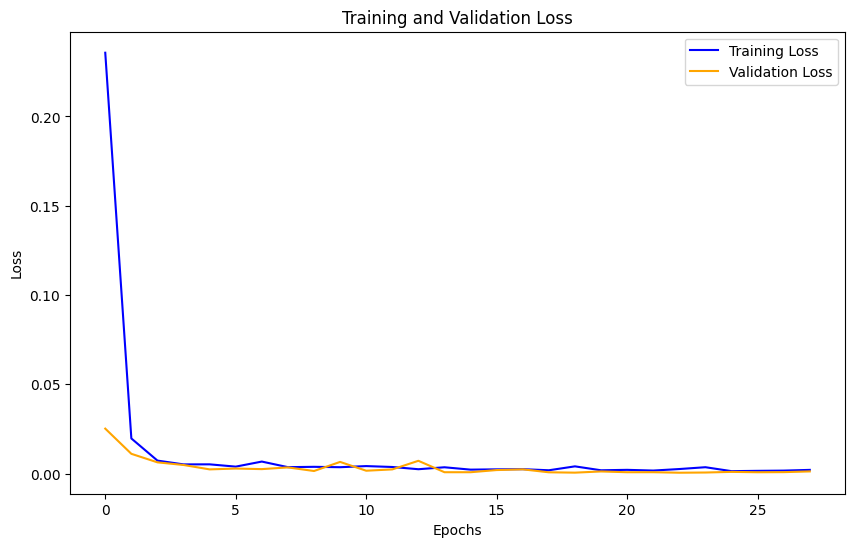

In [50]:
import matplotlib.pyplot as plt

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Show the plot
plt.show()


In [51]:
# Evaluate the model on the test data
test_loss = model_nn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict residuals for the test set
predicted_residuals = model_nn.predict(X_test)

# Display the predicted residuals
print(predicted_residuals[:5])


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4085e-04  
Test Loss: 0.0004642294952645898
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
[[-0.2106774 ]
 [ 0.38703692]
 [ 0.34986496]
 [-0.61393404]
 [-0.3135805 ]]


In [52]:
# Evaluate the model on the test data
test_loss = model_nn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict residuals for the test set
predicted_residuals = model_nn.predict(X_test)

# Display the predicted residuals
print(predicted_residuals[:5])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 4.4085e-04
Test Loss: 0.0004642294952645898
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[-0.2106774 ]
 [ 0.38703692]
 [ 0.34986496]
 [-0.61393404]
 [-0.3135805 ]]


In [53]:
# Calculate the actual OFI for the test data
actual_ofi = (X_test['buy_orders'] - X_test['sell_orders']) / (X_test['buy_orders'] + X_test['sell_orders'])
actual_ofi.fillna(0, inplace=True)  # Handle any NaN values (e.g., when both buy and sell orders are zero)

# Display the actual OFI values
print(actual_ofi.head())


Time
2024-10-14 10:07:08   -0.206349
2024-10-14 10:07:09    0.419355
2024-10-14 10:07:10    0.354839
2024-10-14 10:07:11   -0.636364
2024-10-14 10:07:12   -0.307692
dtype: float64


In [54]:
# Combine VAR predictions and neural network residuals
final_ofi_predictions = predicted_residuals

# Display the predicted OFI values
print(final_ofi_predictions[:5])


[[-0.2106774 ]
 [ 0.38703692]
 [ 0.34986496]
 [-0.61393404]
 [-0.3135805 ]]


In [55]:
final_ofi_predictions

array([[-0.2106774 ],
       [ 0.38703692],
       [ 0.34986496],
       ...,
       [-0.4865657 ],
       [-0.5589571 ],
       [-0.2652068 ]], dtype=float32)

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(actual_ofi, final_ofi_predictions)
mae = mean_absolute_error(actual_ofi, final_ofi_predictions)
r2 = r2_score(actual_ofi, final_ofi_predictions)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')


Mean Squared Error (MSE): 0.0004642294819896727
Mean Absolute Error (MAE): 0.016394303761622597
R-squared: 0.9980330016724618


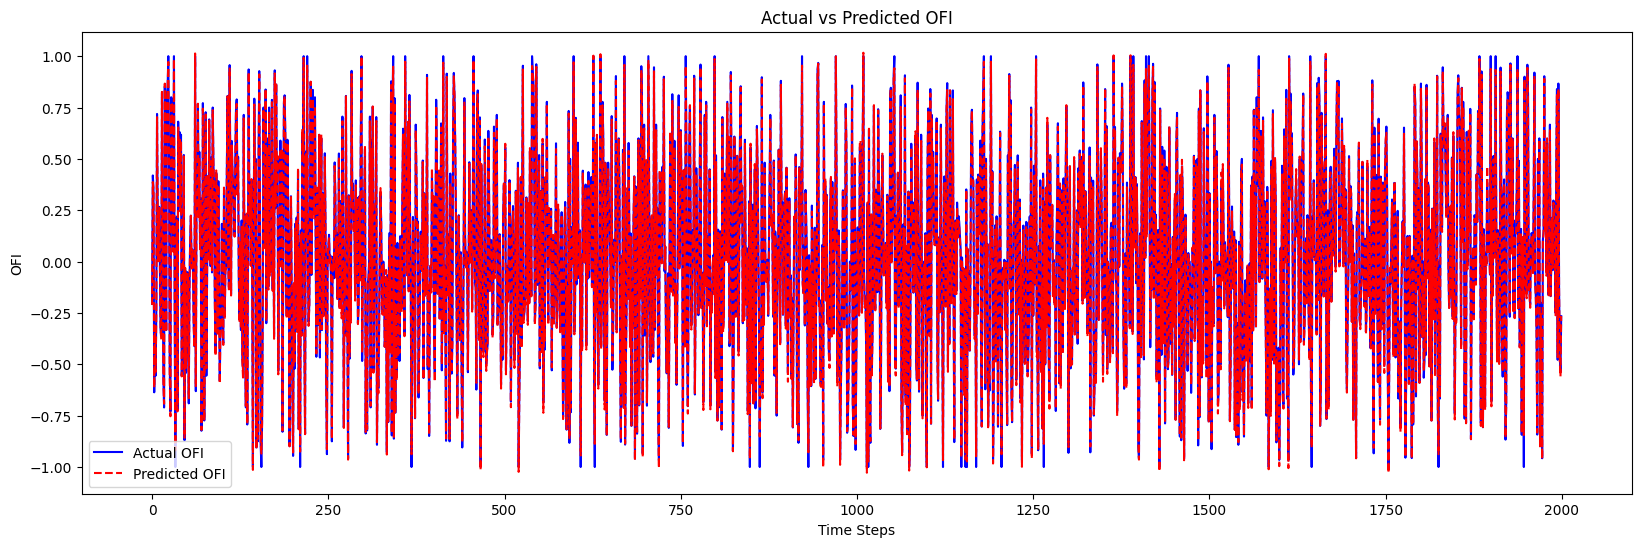

In [57]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted OFI
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi.values, label='Actual OFI', color='blue')
plt.plot(final_ofi_predictions, label='Predicted OFI', color='red', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('Actual vs Predicted OFI')
plt.legend()
plt.show()

-------------------------

Model validation on real data : ETHUSDT

In [58]:
continuation_file_path = 'binance_btcusd_modified_data.csv'
continuation_data = pd.read_csv(continuation_file_path)

# Convert 'Time' column to datetime format and set as index
continuation_data['Time'] = pd.to_datetime(continuation_data['Time'])
continuation_data.set_index('Time', inplace=True)

order_counts_cont=continuation_data

# Display the first few rows of the continuation data
print(order_counts_cont.head())


                     buy_orders  sell_orders
Time                                        
2024-10-22 13:25:48         188            0
2024-10-22 13:25:49           0            6
2024-10-22 13:25:50           6            0
2024-10-22 13:25:51           6            6
2024-10-22 13:25:52           0            3


In [59]:

predicted_residuals_cont = model_nn.predict(order_counts_cont)

# Display the predicted residuals
print(predicted_residuals_cont[:5])


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
[[ 1.8470807 ]
 [-0.9715801 ]
 [ 0.9729459 ]
 [-0.02144527]
 [-0.9735047 ]]


In [60]:


# Calculate the final OFI predictions for the continuation data
final_ofi_predictions_cont = predicted_residuals_cont
 # Handle any NaN values

# Display the final OFI predictions for the continuation data
print(final_ofi_predictions_cont)


[[ 1.8470807 ]
 [-0.9715801 ]
 [ 0.9729459 ]
 ...
 [-1.4867787 ]
 [-1.0275903 ]
 [-0.97596884]]


To reduce within -1 and 1

In [61]:
# Apply the condition to constrain the OFI predictions between -1 and 1
import numpy as np

# Apply the condition to constrain the OFI predictions between -1 and 1
final_ofi_predictions_cont = np.where(final_ofi_predictions_cont > 1,0.9, 
                                      np.where(final_ofi_predictions_cont < -1, -0.9, final_ofi_predictions_cont))

# Display the modified final OFI predictions
print(final_ofi_predictions_cont)


[[ 0.9       ]
 [-0.9715801 ]
 [ 0.9729459 ]
 ...
 [-0.9       ]
 [-0.9       ]
 [-0.97596884]]


In [62]:
order_counts_cont

,buy_orders,sell_orders
Time,,
2024-10-22 13:25:48,188,0
2024-10-22 13:25:49,0,6
2024-10-22 13:25:50,6,0
2024-10-22 13:25:51,6,6
2024-10-22 13:25:52,0,3
...,...,...
2024-10-22 14:13:35,12,40
2024-10-22 14:13:36,3,132
2024-10-22 14:13:37,14,321


In [63]:
order_counts_cont['OFI'] = (order_counts_cont['buy_orders'] - order_counts_cont['sell_orders']) / (order_counts_cont['buy_orders'] + order_counts_cont['sell_orders'])
order_counts_cont['OFI'].fillna(0, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_27252\724105446.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_counts_cont['OFI'].fillna(0, inplace=True)


In [64]:
# # Calculate OFI predictions using only the VAR model for the continuation data
# var_ofi_predictions_cont = (var_forecast_df_cont['buy_orders_forecast'] - var_forecast_df_cont['sell_orders_forecast']) / (var_forecast_df_cont['buy_orders_forecast'] + var_forecast_df_cont['sell_orders_forecast'])
# var_ofi_predictions_cont.fillna(0, inplace=True)

# # Compare VAR-only OFI with actual OFI from continuation data
actual_ofi_cont = order_counts_cont['OFI']

# # Calculate evaluation metrics for the VAR-only model
# mse_var = mean_squared_error(actual_ofi_cont, var_ofi_predictions_cont)
# mae_var = mean_absolute_error(actual_ofi_cont, var_ofi_predictions_cont)
# r2_var = r2_score(actual_ofi_cont, var_ofi_predictions_cont)

# print(f'VAR-only Model - MSE: {mse_var}, MAE: {mae_var}, R-squared: {r2_var}')


In [79]:
# Calculate evaluation metrics for the combined model
mse_combined = mean_squared_error(actual_ofi_cont, final_ofi_predictions_cont)
mae_combined = mean_absolute_error(actual_ofi_cont, final_ofi_predictions_cont)
r2_combined = r2_score(actual_ofi_cont, final_ofi_predictions_cont)

print(f'FnN Model - MSE: {mse_combined}, MAE: {mae_combined}, R-squared: {r2_combined}')


FnN Model - MSE: 0.020111390703949683, MAE: 0.07844779316914745, R-squared: 0.970160879765685


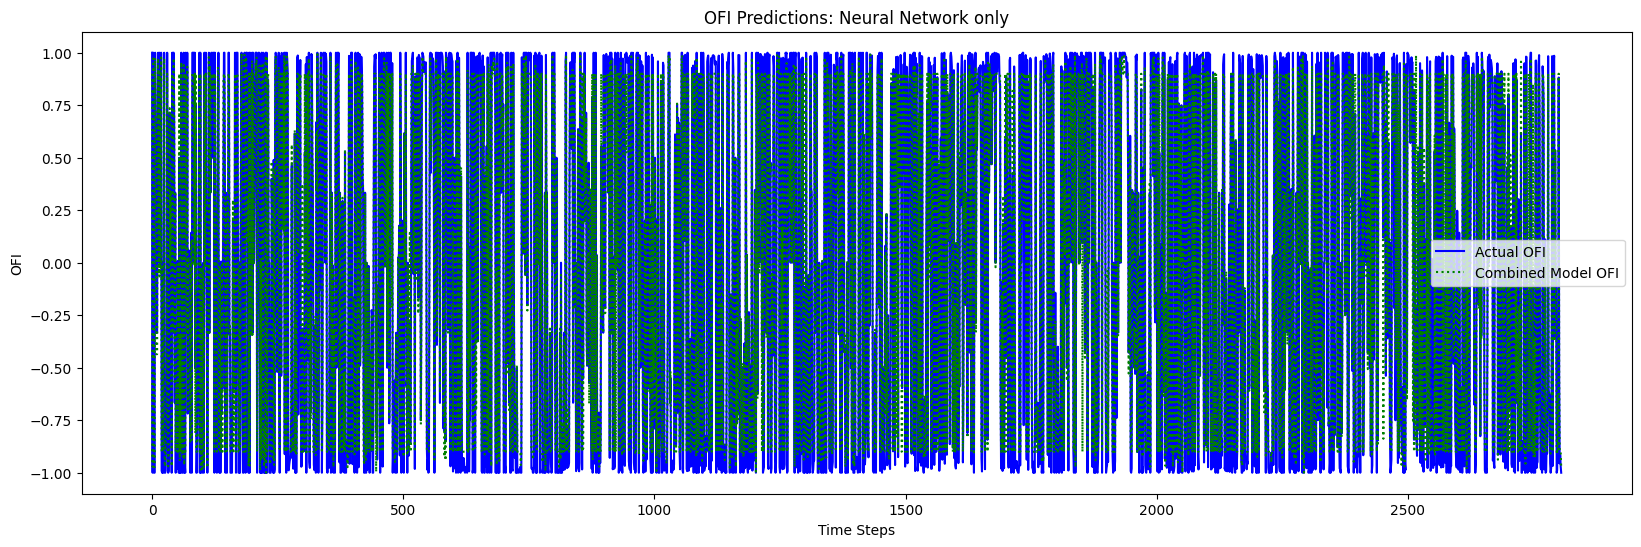

In [81]:
# Plot actual OFI vs predicted OFI from both models
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
# plt.plot(var_ofi_predictions_cont.values, label='VAR-only OFI', color='black', linestyle='dashed')
plt.plot(final_ofi_predictions_cont, label='Combined Model OFI', color='green', linestyle='dotted')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Predictions: Neural Network only')
plt.legend()
plt.show()


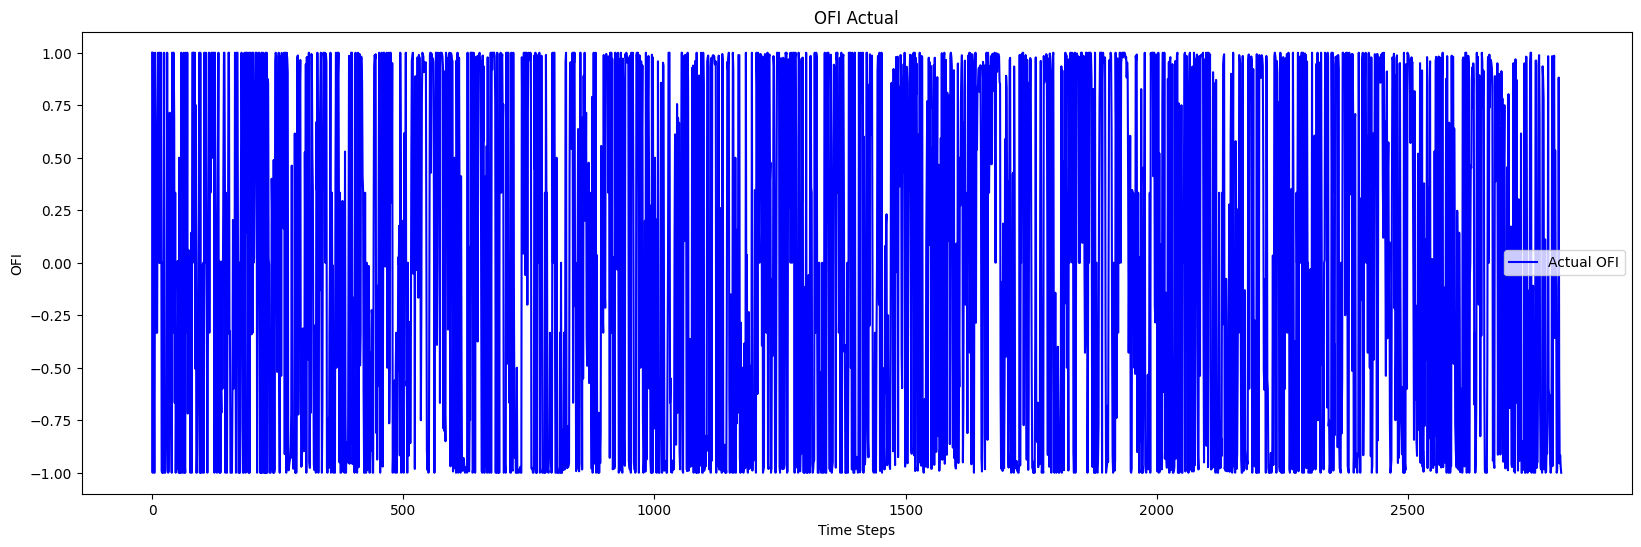

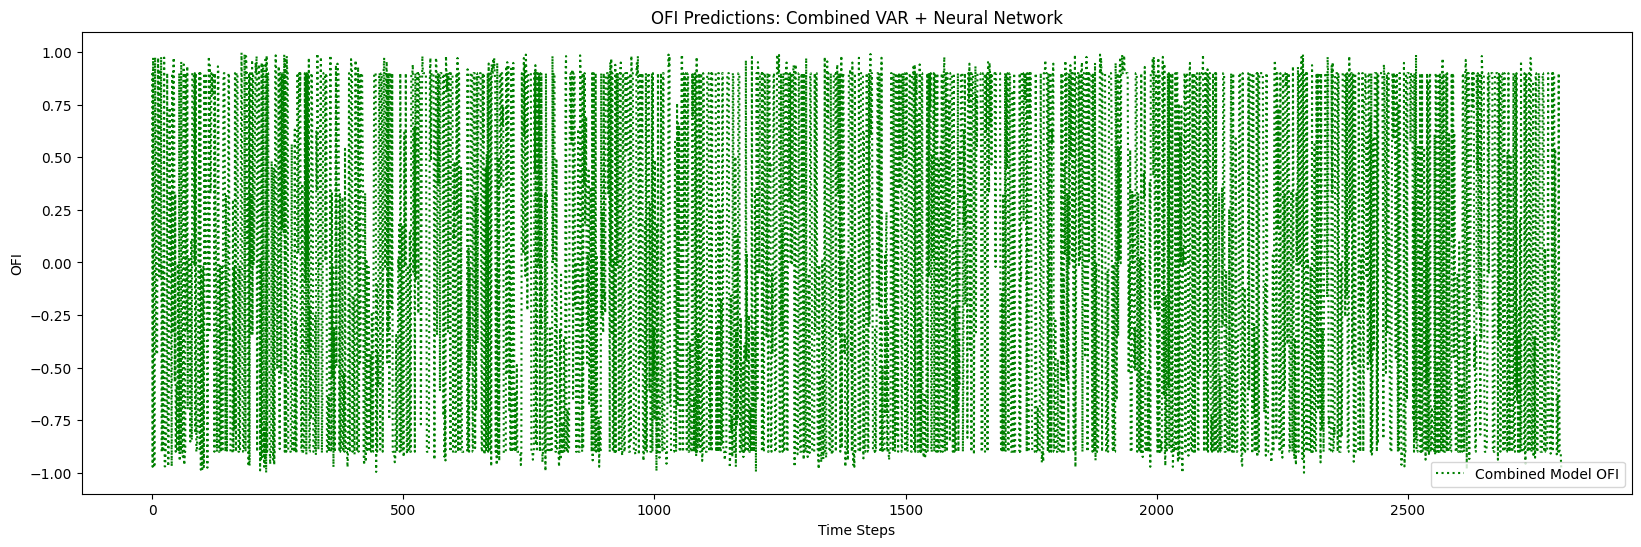

In [67]:
# Plot 
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Actual')
plt.legend()
plt.show()

# Plot 
plt.figure(figsize=(20, 6))
plt.plot(final_ofi_predictions_cont, label='Combined Model OFI', color='green', linestyle='dotted')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Predictions: Combined VAR + Neural Network')
plt.legend()
plt.show()

In [68]:
# Combine actual and predicted OFI into a DataFrame

final_ofi_predictions_cont = np.ravel(final_ofi_predictions_cont)

comparison_df = pd.DataFrame({
    'Actual_OFI': actual_ofi_cont.values,
    'FNN_Model_OFI': final_ofi_predictions_cont
})

# Display the DataFrame
print(comparison_df.head())


   Actual_OFI  FNN_Model_OFI
0         1.0       0.900000
1        -1.0      -0.971580
2         1.0       0.972946
3         0.0      -0.021445
4        -1.0      -0.973505


In [69]:
comparison_df

,Actual_OFI,FNN_Model_OFI
0,1.000000,0.900000
1,-1.000000,-0.971580
2,1.000000,0.972946
3,0.000000,-0.021445
4,-1.000000,-0.973505
...,...,...
2801,-0.538462,-0.525273
2802,-0.955556,-0.900000
2803,-0.916418,-0.900000
2804,-0.970588,-0.900000


In [70]:
def ofi_to_signal(ofi):
    if ofi > 0:
        return 'BUY'
    elif ofi < 0:
        return 'SELL'
    else:
        return 'HOLD'

In [71]:
comparison_df['actual_signal'] = comparison_df['Actual_OFI'].apply(ofi_to_signal)
# comparison_df['forecasted_VAR_signal'] = comparison_df['VAR_Only_OFI'].apply(ofi_to_signal)
comparison_df['FNN_signal'] = comparison_df['FNN_Model_OFI'].apply(ofi_to_signal)


In [72]:
# Convert actual and predicted OFI to binary labels (1 for positive, 0 for negative)
actual_ofi_labels = (actual_ofi_cont > 0).astype(int)
# var_ofi_labels = (var_ofi_predictions_cont > 0).astype(int)
combined_ofi_labels = (final_ofi_predictions_cont > 0).astype(int)


In [73]:
actual_ofi_labels

Time
2024-10-22 13:25:48    1
2024-10-22 13:25:49    0
2024-10-22 13:25:50    1
2024-10-22 13:25:51    0
2024-10-22 13:25:52    0
                      ..
2024-10-22 14:13:35    0
2024-10-22 14:13:36    0
2024-10-22 14:13:37    0
2024-10-22 14:13:38    0
2024-10-22 14:13:39    0
Name: OFI, Length: 2806, dtype: int32

In [74]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for VAR-only model and combined model
# accuracy_var = accuracy_score(actual_ofi_labels, var_ofi_labels) * 100
accuracy_combined = accuracy_score(actual_ofi_labels, combined_ofi_labels) * 100

# print(f'VAR-only Model Accuracy: {accuracy_var:.2f}%')
print(f' FNN Model Accuracy: {accuracy_combined:.2f}%')


 FNN Model Accuracy: 97.43%


In [75]:
from sklearn.metrics import precision_score

# Calculate precision for VAR-only model and combined model
# precision_var = precision_score(actual_ofi_labels, var_ofi_labels) * 100
precision_combined = precision_score(actual_ofi_labels, combined_ofi_labels) * 100

# print(f'VAR-only Model Precision: {precision_var:.2f}%')
print(f' FNN Model Precision: {precision_combined:.2f}%')


 FNN Model Precision: 96.82%


In [76]:
comparison_df

,Actual_OFI,FNN_Model_OFI,actual_signal,FNN_signal
0,1.000000,0.900000,BUY,BUY
1,-1.000000,-0.971580,SELL,SELL
2,1.000000,0.972946,BUY,BUY
3,0.000000,-0.021445,HOLD,SELL
4,-1.000000,-0.973505,SELL,SELL
...,...,...,...,...
2801,-0.538462,-0.525273,SELL,SELL
2802,-0.955556,-0.900000,SELL,SELL
2803,-0.916418,-0.900000,SELL,SELL
2804,-0.970588,-0.900000,SELL,SELL


In [82]:
comparison_df.to_csv('Modelling_fnn_only_BTCUSDT.csv')

In [77]:
# accuracy_1 = (comparison_df['actual_signal'] == comparison_df['forecasted_VAR_signal']).mean()
# print(f"OFI VAR Prediction Accuracy: {accuracy_1 * 100:.2f}%")

accuracy_2 = (comparison_df['actual_signal'] == comparison_df['FNN_signal']).mean()
print(f"OFI fnn Model Prediction Accuracy: {accuracy_2 * 100:.2f}%")

OFI fnn Model Prediction Accuracy: 94.83%


In [80]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between 'Actual_OFI' and 'Combined_Model_OFI'
mse = mean_squared_error(comparison_df['Actual_OFI'], comparison_df['FNN_Model_OFI'])
# mse2 = mean_squared_error(comparison_df['Actual_OFI'], comparison_df['VAR_Only_OFI'])
print(f"Mean Squared Error on  FNN model (MSE): {mse}")
# print(f"Mean Squared Error on VAR linear model  (MSE): {mse2}")

Mean Squared Error on  FNN model (MSE): 0.020111390703949683




-------------------

Done.